In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import spearmanr
import csv

import warnings
warnings.filterwarnings("ignore")

In [2]:
# setting = "wd=0.01_lr=3e-5"
setting = "wd=0.0_lr=5e-5"

In [3]:
def read_nodes(file_path):
    int_list = []
    with open(file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            for item in row:
                try:
                    int_list.append(int(item))
                except ValueError:
                    print(f"Warning: '{item}' could not be converted to an integer and was skipped.")
    return int_list

def calculate_one(path, setting):
    try:
        score = torch.load(path, map_location=torch.device('cpu'))
        score /= 2048 ** 0.5

        # Prepare node list
        nodes_str = [f"./checkpoints/{setting}/{i}/train_index.csv" for i in range(50)]
        full_nodes = list(range(4656))
        node_list = []
        for node_str in nodes_str:
            numbers = read_nodes(node_str)
            index = [full_nodes.index(number) for number in numbers]
            node_list.append(index)

        # Load ground truth
        loss_list = torch.load(f"./results/{setting}/gt.pt", map_location=torch.device('cpu')).detach()

        # Calculate approximations
        approx_output = []
        for i in range(len(nodes_str)):
            score_approx_0 = score[node_list[i], :]
            sum_0 = torch.sum(score_approx_0, axis=0)
            approx_output.append(sum_0)

        # Calculate correlations
        res = 0
        counter = 0
        for i in range(score.shape[1]):
            tmp = spearmanr(
                np.array([approx_output[k][i] for k in range(len(approx_output))]),
                np.array([loss_list[k][i].numpy() for k in range(len(loss_list))])
            ).statistic
            if not np.isnan(tmp):
                res += tmp
                counter += 1

        return res/counter if counter > 0 else float('nan'), loss_list, approx_output
    except (FileNotFoundError, RuntimeError) as e:
        return None, None, None

In [4]:
def extract_from_log(log_path):
    try:
        with open(log_path, 'r') as f:
            content = f.read()

            # Extract time
            time_match = re.search(r'Time taken: (\d+\.?\d*) seconds', content)
            time_taken = float(time_match.group(1)) if time_match else None

            # Extract memory
            memory_match = re.search(r'Peak memory usage: (\d+\.?\d*) MB', content)
            peak_memory = float(memory_match.group(1)) if memory_match else None

            return time_taken/60, peak_memory/1024  # Convert seconds to minutes and MB to GB
    except FileNotFoundError:
        return 0, 0

def visualize_comprehensive_results(setting):
    methods = {
        'GIP': {
            'projections': ['SJLT-1024(NU)', 'SJLT-2048(NU)', 'SJLT-4096(NU)', 'SJLT-32(U)', 'SJLT-64(U)', 'SJLT-128(U)'],
            'thresholds': [0.0, 0.001],
            'pattern': lambda p, t: f"GIP-default_{p}_thrd-{t}.pt",
            'special': ['iterate']
        },
        'GD': {
            'projections': ['FJLT-1024', 'SJLT-1024', 'FJLT-2048', 'SJLT-2048', 'FJLT-4096', 'SJLT-4096'],
            'thresholds': [0.0, 0.001],
            'pattern': lambda p, t: f"GD-default_{p}_thrd-{t}.pt"
        },
        'TRAK': {
            'projections': ['FJLT-1024', 'SJLT-1024', 'FJLT-2048', "SJLT-2048"],
            'thresholds': [0.0, 0.001],
            'pattern': lambda p, t: f"TRAK-default_{p}_thrd-{t}.pt"
        }
    }

    results, times, memories, labels, bar_colors, alphas = [], [], [], [], [], []
    colors = {'GIP': '#2ca02c', 'GD': '#1f77b4', 'TRAK': '#ff7f0e'}
    alpha_map = {0.0: 1.0, 0.001: 0.5}

    # Collect results
    for method, config in methods.items():
        if 'special' in config:
            for special_case in config['special']:
                base_path = f"./results/{setting}/{method}-{special_case}"
                result = calculate_one(f"{base_path}.pt", setting)[0]
                time_taken, peak_memory = extract_from_log(f"{base_path}.log")

                if result is not None:
                    results.append(result)
                    times.append(time_taken)
                    memories.append(peak_memory)
                    labels.append("iterate")
                    bar_colors.append(colors[method])
                    alphas.append(1.0)

        for proj in config['projections']:
            for thrd in config['thresholds']:
                base_path = f"./results/{setting}/{config['pattern'](proj, thrd).replace('.pt', '')}"
                result = calculate_one(f"{base_path}.pt", setting)[0]
                time_taken, peak_memory = extract_from_log(f"{base_path}.log")

                if result is not None:
                    results.append(result)
                    times.append(time_taken)
                    memories.append(peak_memory)
                    labels.append(f"{proj}")
                    bar_colors.append(colors[method])
                    alphas.append(alpha_map[thrd])

    # Create plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), height_ratios=[1, 1, 1])

    def create_bars(ax, values, title):
        bars = []
        for i, (value, color, alpha) in enumerate(zip(values, bar_colors, alphas)):
            bar = ax.bar(i, value, width=0.6, color=color, alpha=alpha)
            bars.extend(bar)

        ax.set_ylabel(title, fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        return bars

    # Create all plots
    bars1 = create_bars(ax1, results, 'LDS Score')
    bars2 = create_bars(ax2, times, 'Time (mins)')
    bars3 = create_bars(ax3, memories, 'Memory (GB)')

    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height is not None:
                ax = bar.axes
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}', ha='center', va='bottom')

    # Set x-axis labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xticks(np.arange(len(results)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

    # Create two separate legends
    method_legend = ax1.legend(handles=[plt.Rectangle((0, 0), 1, 1, fc=color, label=method)
                                      for method, color in colors.items()],
                              title='Methods',
                              loc='upper left',
                              bbox_to_anchor=(0, 0.97))

    threshold_legend = ax1.legend(handles=[plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=alpha,
                                         label=f'{thrd}')
                                         for thrd, alpha in alpha_map.items()],
                                 title='Thresholds',
                                 loc='upper left',
                                 bbox_to_anchor=(0.1, 0.97))

    # Add both legends
    ax1.add_artist(method_legend)
    ax1.add_artist(threshold_legend)

    plt.tight_layout()
    plt.show()

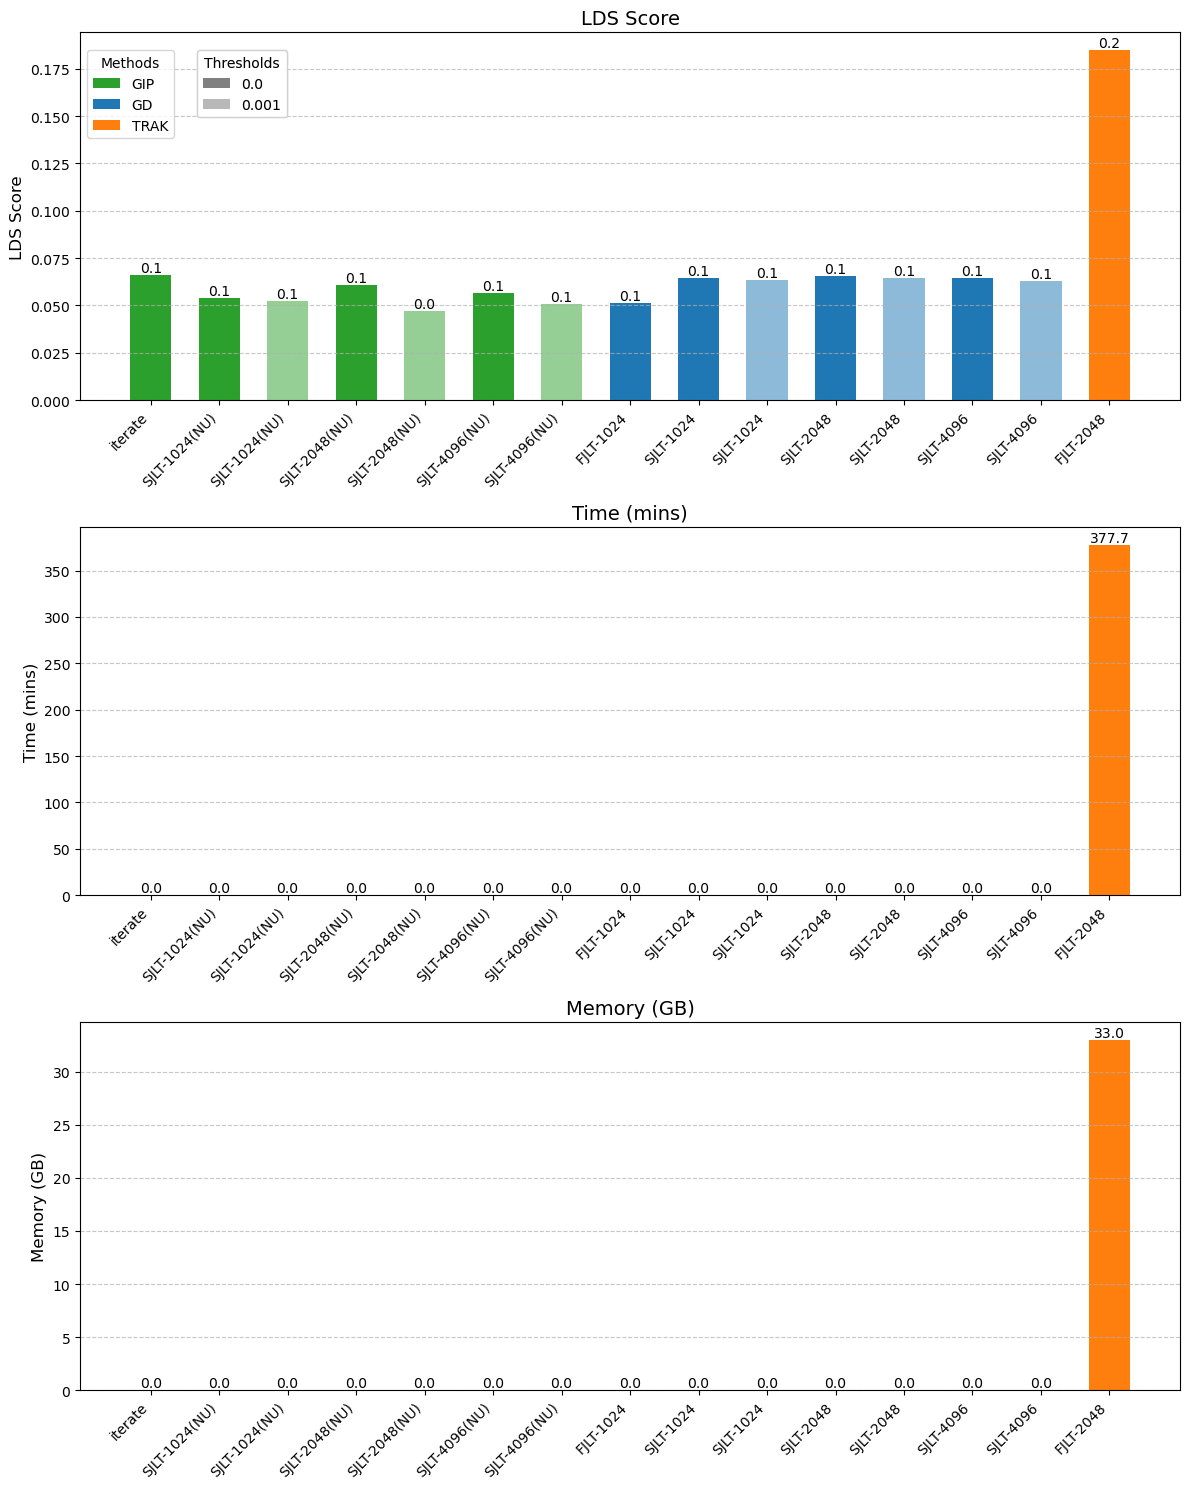

In [5]:
visualize_comprehensive_results(setting)

In [6]:
def visualize_sparsity(setting):
    methods = {
        'GIP': {'pattern': 'GIP-default_sparsity.pt'},
        'GD': {'pattern': 'GD-default_sparsity.pt'}
    }
    colors = {'GIP': '#2ca02c', 'GD': '#1f77b4', 'TRAK': '#ff7f0e'}

    gip_data = torch.load(f"./results/{setting}/{methods['GIP']['pattern']}")
    gd_data = torch.load(f"./results/{setting}/{methods['GD']['pattern']}")

    thresholds = sorted(list(gip_data.keys()))
    layers = list(gip_data[thresholds[0]].keys())
    x = range(len(layers))

    fig, axes = plt.subplots(len(thresholds), 1, figsize=(12, 3*len(thresholds)))

    for t_idx, threshold in enumerate(thresholds):
        ax = axes[t_idx]

        # Plot GIP values
        val1 = [gip_data[threshold][layer]['val_1'] for layer in layers]
        val2 = [gip_data[threshold][layer]['val_2'] for layer in layers]
        ax.plot(x, val1, label='Input', color=colors['GIP'])
        ax.plot(x, val2, linestyle='--', label='∇pre-activation', color=colors['GIP'])

        # Plot GD line
        gd_value = gd_data[threshold]['checkpoint_0']
        ax.axhline(y=gd_value, color=colors['GD'], linestyle='-', label='Gradient')

        ax.set_xlabel('Layer')
        ax.set_ylabel('Sparsity')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'Threshold = {threshold:.1e}')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [7]:
visualize_sparsity(setting)

FileNotFoundError: [Errno 2] No such file or directory: './results/wd=0.0_lr=5e-5/GIP-default_sparsity.pt'

In [8]:
#compare gt_GIPGPT2.pt and gt.pt

gt_1 = torch.load(f"./results/{setting}/gt_GIPGPT2.pt", map_location=torch.device('cpu')).detach()
gt_2 = torch.load(f"./results/{setting}/gt.pt", map_location=torch.device('cpu')).detach()

print(torch.allclose(gt_1, gt_2, atol=1e-6))

True
